# Awkward arrays

For particle physicists, the complex data structures are usually difficult to handle with regular python arrays (and dataframes). For example, what if you want to create arrays/dataframes that contain the muons from the collision events? If each row represents an event, what will be the shape of the dataframe?  Since an event may have any number of muons, the dataframe does not have a distinct shape. This is what I am talking about -
<img src="images/ragged_array.png" alt="" width="300" height="200">
As you can see, this data structure do not have a distinct shape like a numpy array or a pandas dataframe. An awkward array is a specialized data structure used in scientific computing that can handle irregular and nested data like this. You can find the official documentation <a href="https://awkward-array.org/doc/main/">here</a>.

> **NOTE :** The contents of the following exercise are taken from the HSF-India Training Event, which was organised by TIFR in May 2023. The instructor, Jim Pivarski is a computational physicist from Princeton. The original content can be found <a href="https://github.com/hsf-india-may2023/scientific-python/tree/main">here</a>.

# Higgs decay example
In order to work with awkward arrays, let's pick something specific. In this example, I have a standard model process $H\rightarrow ZZ \rightarrow 4l$ in the `data` folder. The data is organised in various formats. I will use the parquet file, turn it into an awkward array and make plots and filter events.

For reading this file, some additional packages like `pyarrow` and `fsspec` need to be installed. If you don't have the necessary packages, you can install them with pip (or any other package manager).

```
pip install awkward1
pip install pyarrow
pip install fsspec
```

I am using `awkward1` instead of `awkward`, which is the new version and is actively maintained and developed. The previous version has incompatibility issues with recent versions of `numpy`. Operationally they are identical. Now, let's import the modules for this exercise.

In [1]:
import awkward1 as ak
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Let's create the awkward array from the input dataset.

In [2]:
events = ak.from_parquet("data/SMHiggsToZZTo4L.parquet")

### Interpreting this awkward data in json-like format
Each row in this awkward dataset represents one collision event. You can think of this whole thing as a list, where each entry is one event.
```
[
    {run:1, event:1, electron:[...], muon:[...] ...},
    {run:1, event:2, electron:[...], muon:[...] ...},
]
```
Each event is a dictionary containing key-value pairs. That means, for the first element/event in this list (say),
- if you access the 'run' key, it will give you the corresponding value, which is 1.
- if you access 'electron', it will give you a list of electrons, where each entry is a dictionary of electron properties.

### Data structure of a single event
Let's print out the first event and see how it looks like.

In [3]:
events[0].to_list()

{'run': 1,
 'luminosityBlock': 156,
 'event': 46501,
 'PV': {'x': 0.24369880557060242,
  'y': 0.3936990201473236,
  'z': 1.451307773590088},
 'electron': [],
 'muon': [{'pt': 63.04386901855469,
   'eta': -0.7186822295188904,
   'phi': 2.968005895614624,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso03_all': 0.0,
   'pfRelIso04_all': 0.0,
   'dxy': -0.004785160068422556,
   'dxyErr': 0.0060764215886592865,
   'dz': 0.09005985409021378,
   'dzErr': 0.044572051614522934},
  {'pt': 38.12034606933594,
   'eta': -0.8794569969177246,
   'phi': -1.0324749946594238,
   'mass': 0.10565836727619171,
   'charge': -1,
   'pfRelIso03_all': 0.0,
   'pfRelIso04_all': 0.0,
   'dxy': 0.0005746808601543307,
   'dxyErr': 0.0013040687190368772,
   'dz': -0.0032290113158524036,
   'dzErr': 0.003023269586265087},
  {'pt': 4.04868745803833,
   'eta': -0.320764422416687,
   'phi': 1.0385035276412964,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso03_all': 0.0,
   'pfRelIso04_all': 0.

**What does it mean?**

The whole event is a dictionary containing numbers and lists.
- 'run', 'luminosityBlock' and 'event' are simple numbers.
- 'electron' is an empty list.
- The muon list contains 3 items, each is a dictionary carrying muon properties.
- The muon list seems to be sorted (descending) according to pT. <br>(This is how the input file was generated.)
- The charges of the muons are : 1, -1 and 1.
- MET is a dictionary carrying pT and phi. <br>(Can you guess why it's not a list of dictionaries?)
- PV is also a dictionary carrying the x, y, z coordinates.

**This is a 3mu1e event.**

This is the beauty of awkward arrays!<br>The next event may contain a different number of electrons and muons. It will only affect the length of the electron/muon lists. It may not be a nice list with a fixed shape, but the organizational strauture is fixed. Once you understand the structure, you can work with any electrons/muons from any event.

### Plotting a variable : pT of all electrons
Let's pick all the electrons from all the events and make a pT plot.
The variable we are interested is simply - `events.electron.pt`. It is of the type : `awkward.highlevel.Array` and has the following structure.
```
[
    [],
    [21.9, 42.6, 78, 23.8],
    [11.6, 6.69],
    [10.4],
    ......
]
----------------------------
type: 299973 * var * float32
```
This means,
- It is a list of 299973 objects, each of which represents one event. <br>(There are 299973 events in total).
- Each entry is again a list of electron pTs.
- The first entry is an empty list, because the first event did not have any electrons.
- The second entry is a list of 4 numbers, corresponding to the pT of the 4 electrons in the second event. <br><br>... and so on.

Remeber that 'events' is a list of dictionaries. So, `events.electron` is picking the list of dictionaries corresponding to the 'electron' key in events. Then, `events.electron.pt` is picking all the 'pt' values from the electron dictionaries. This is how you end up with a very complicated *lists-within-lists* structure as shown above. However, in order to plot it as a histogram, we need a list of numbers without structure. That's why we have to `ak.flatten` it.

In [4]:
all_electron_pt = ak.flatten(events.electron.pt)
print(type(all_electron_pt))
print(all_electron_pt)

<class 'awkward.highlevel.Array'>
[21.9, 42.6, 78, 23.8, 11.6, 6.69, 10.4, ..., 48, 12.3, 17.9, 23.2, 48.1, 38.7]


Good! Now we can make a simple histogram.

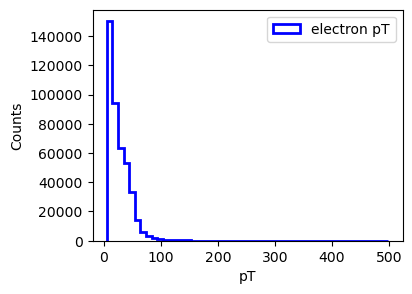

In [5]:
fig1, ax1 = plt.subplots(1,1,figsize=(4,3))
ax1.hist(all_electron_pt, bins=50, histtype='step', linewidth=2, color='blue', label='electron pT')
ax1.set_xlabel('pT')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')
ax1.set_title('')
plt.show()

By taking the given variables in the dataset, we can also caclculate complicated varibales. For example, in order to compute $p_z = p_T\sinh\eta$, we can simpy do the following.
```
all_electron_pz = events.electron.pt * np.sinh(events.electron.eta)
```
Let's look at some basic operations that we can do on awkward arrays.

# Basic operations of Awkward Array

Let's pick a simpler dataset for this. The following is a list of lists. Each inner list contains dictionaries with keys 'x' and 'y'. 'x' corresponds to simple numbers, 'y' corresponds to lists of numbers.

In [6]:
array=[
    [
        {"x": 1.1, "y": [1]},
        {"x": 2.2, "y": [1, 2]}
    ],
    [
        
    ],
    [
        {"x": 3.3, "y": [1, 2, 3]}
    ]
]

'array[0]' gives the first element of 'array', which is a list containing two dictionaries.

In [7]:
array[0]

[{'x': 1.1, 'y': [1]}, {'x': 2.2, 'y': [1, 2]}]

Similarly, `array[0][0]` will give the first dictionary in this list, and `array[0][0]["x"]` will give the value for 'x' in that dictionary.

In [8]:
array[0][0]['x']

1.1

Note that, this array is not like a regular 3x3 array of numbers. You can't define a definite shape. Awkward operations let you do complicated mathematical operations that apply to lists of variable length, including zero length. Let's create an awkward array from this array, and try to do some simple calculations.

In [10]:
awkarr = ak.from_iter(array)
print(f'The zero-th element:\t\t\t\t\t {awkarr[0]}')
print(f'All the "y"s from the zero-th element:\t\t\t {awkarr[0, "y"]}')
print(f'All the last entries in "y"s from the zero-th element:\t {awkarr[0, "y", -1]}')
print(f'Sum of all the "x" in the array :\t\t\t {ak.sum(awkarr["x"])}')
print(f'Sum of all the "y" elements (in the same dict):\t\t {ak.sum(awkarr["y"], axis=-1)}')

The zero-th element:					 [{x: 1.1, y: [1]}, {x: 2.2, y: [1, 2]}]
All the "y"s from the zero-th element:			 [[1], [1, 2]]
All the last entries in "y"s from the zero-th element:	 [1, 2]
Sum of all the "x" in the array :			 6.6
Sum of all the "y" elements (in the same dict):		 [[1, 3], [], [6]]


Some of these features are very similar to NumPy. The `axis` parameter has the same meaning as in NumPy, but it is extended to work with non-rectilinear data. Slicing of such complicated arrays can be done with booleans. For example,

In [11]:
print(f'Only the last element of awkarray is shown: {awkarr[[False, False, True]]}')
print(f'Only the "y" elements: \t\t\t    {awkarr.y}')
print(f'Only the selected entries in "y" elements:  {awkarr.y[ [[[True], [False, True]], [], [[False, True, False]]] ]}')

Only the last element of awkarray is shown: [[{x: 3.3, y: [1, 2, 3]}]]
Only the "y" elements: 			    [[[1], [1, 2]], [], [[1, 2, 3]]]
Only the selected entries in "y" elements:  [[[1], [2]], [], [[2]]]


This **boolean-filtering** is going to be extremely useful for us.<br>
Let's try another example where there are some missing variables, and `None` types.

In [12]:
array2 = ak.from_iter([[   1,    2,    4],
                       [                ],
                       [None,    8      ],
                       [  16            ]])

In [13]:
print(f'Sum along axis-0 (vertically)   : {ak.sum(array2, axis=0)}')
print(f'Sum along axis-1 (horizontally) : {ak.sum(array2, axis=1)}')

Sum along axis-0 (vertically)   : [17, 10, 4]
Sum along axis-1 (horizontally) : [7, 0, 8, 16]


Python is really smart. You don't have to worry about data types as much as in C++.

# Filtering using booleans

Coming back to our physics example, we can filter events in a very simple way. Suppose we want all events containing MET>20. Now, for each event, we can have an array of booleans defined by `events.MET.pt > 20`. The following block shows how the array of MET and the array of booleans look like.

In [14]:
print(f'List of MET pt in each event : \t   {events.MET.pt}')
print(f'List of booleans for MET pt > 20 : {events.MET.pt > 20}')

List of MET pt in each event : 	   [21.9, 17, 19.1, 30.9, 14.4, 11.5, 6.33, ..., 19.5, 33, 18.3, 17.7, 24, 12.9]
List of booleans for MET pt > 20 : [True, False, False, True, False, False, ..., True, False, False, True, False]


Each array contains 299973 entries (you can check it by printing `len(events.MET.pt)`); one entry for each event. We only want to keep those events that correspond to 'True' in the boolean array. We can use the syntax for boolean filtering, as we learned previously. Let's apply this and see how many events are filetered out. This filtering is analogous to pandas dataframes.

In [15]:
print(f'No. of events before the MET cut : {len(events)}')
print(f'No. of events after the MET cut :  {len(events[events.MET.pt > 20])}')

No. of events before the MET cut : 299973
No. of events after the MET cut :  163222


#### `len()` vs `ak.num()`
`len()` is a general Python function that returns the number of *only the top-level elements* in an object that supports the concept of length. That's why `len(events.electron)` returns the length of events, instead of electrons in events. In such cases, `ak.num()` is used. For example,

In [16]:
print(f'No. of electrons in each event: \t    {ak.num(events.electron)}')
print(f'No. of electrons in each event with pT>30 : {ak.num(events.electron[events.electron.pt > 30])}')

No. of electrons in each event: 	    [0, 4, 2, 1, 4, 1, 1, 1, 4, 0, 2, 3, 4, ..., 1, 2, 5, 2, 1, 0, 3, 0, 1, 0, 2, 2]
No. of electrons in each event with pT>30 : [0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, ..., 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2]


Here `ak.num()` returns a list. So, if you want to calculate the total number of electrons across all events that pass this pT cut, you can simply sum over the array in the horizontal axis.<br>

Now, let's make a pT plot for this subset. I will overlay it with the original pT plot.<br>
The list of electron pt (>30)  is basically a flattened version of `events.electrons[filter].pt`.<br>
Note that **the filter is applied on electrons, and not on events**.

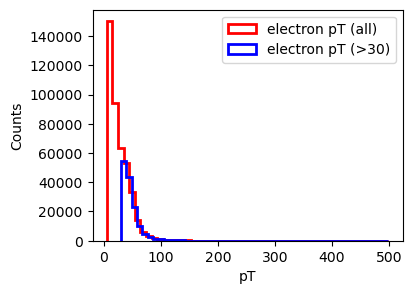

In [22]:
elept_g30 = ak.flatten(events.electron[events.electron.pt > 30].pt)

fig2, ax2 = plt.subplots(1,1,figsize=(4,3))
ax2.hist(all_electron_pt, bins=50, histtype='step', linewidth=2, color='red', label='electron pT (all)')
ax2.hist(elept_g30, bins=50, histtype='step', linewidth=2, color='blue', label='electron pT (>30)')
ax2.set_xlabel('pT')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')
ax2.set_title('')
plt.show()

# Combinatorics

How to combine two awkward arrays? 
